# 0. Basics

## 0.0. Imports

In [1]:
import primod
import imod
from imod import msw
from imod import mf6

In [2]:
import importlib.metadata as md, json, pathlib, imod, primod
from imod.mf6 import GroundwaterFlowModel as GWF

print("imod:", md.version("imod"))
print("primod path:", primod.__file__)
du = next(p for p in md.distribution("primod").files if p.name=="direct_url.json")
print("primod commit:", json.loads(pathlib.Path(md.distribution("primod").locate_file(du)).read_text())["vcs_info"]["commit_id"])
print("has get_diskey:", hasattr(GWF, "get_diskey"))

imod: 1.0.0rc7
primod path: g:\.pixi\envs\default\Lib\site-packages\primod\__init__.py
primod commit: f2628433d07087f867c36219dbbe1c86f9778bbb
has get_diskey: True


In [3]:
import importlib as IL
IL.reload(primod)
IL.reload(imod)

<module 'imod' from 'g:\\.pixi\\envs\\default\\Lib\\site-packages\\imod\\__init__.py'>

In [4]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [5]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G
from WS_Mdl.utils import bold, style_reset

In [6]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [7]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import LineString, MultiLineString, box
from shapely.ops import linemerge

In [8]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import contextlib

In [9]:
import DRN_SFR_match
from DRN_SFR_match import match_cells_to_SFR
import w_MVR
from w_MVR import w_MVR

## 0.1. Options

In [10]:
MdlN = 'NBr44'
Pa_Gpkg = PJ(U.Pa_WS, rf"g:\models\NBr\PrP\SFR\BrabantseDelta\Gpkg\WBD_detail_SW_NW_cleaned_{MdlN}.gpkg")

In [11]:
U.set_verbose(False)

In [12]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

Could not determine imod version Sim/NBr44 folder doesn't exist, or it's structure has been modified.
 Proceeding with the assumption that it's imod_python.
Could not determine imod version Sim/NBr44 folder doesn't exist, or it's structure has been modified.
 Proceeding with the assumption that it's imod_python.


In [13]:
U.Mdl_Dmns_from_INI(d_Pa['INI'])

(113100.0, 387600.0, 125100.0, 396200.0, 25.0, 344, 480)

In [14]:
l_X_Y_Cols = ['Xstart', 'Ystart', 'Xend', 'Yend']
l_Circ_IDs = [6561, 8788, 18348]

# 1. Load Model Ins

## 1.0. Load PRJ

In [17]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [18]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## 1.1. Load DIS and limit to Mdl Aa

In [19]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

Could not determine imod version Sim/NBr44 folder doesn't exist, or it's structure has been modified.
 Proceeding with the assumption that it's imod_python.
Could not determine imod version Sim/NBr44 folder doesn't exist, or it's structure has been modified.
 Proceeding with the assumption that it's imod_python.


In [20]:
BND = PRJ_regrid['bnd']['ibound']

In [21]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


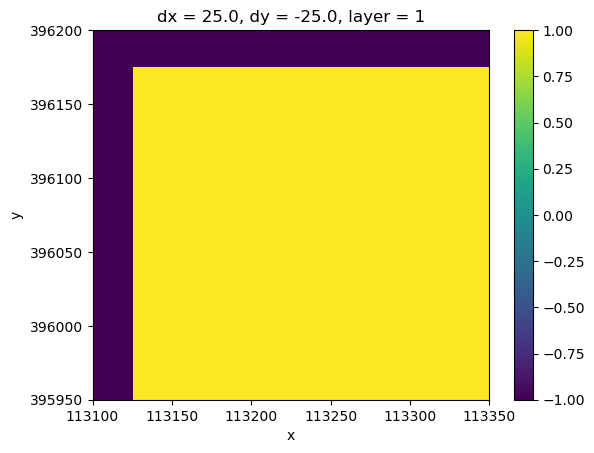

In [22]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## 1.2. Load MF6 Mdl

In [23]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [24]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

In [25]:
MF6_Mdl = Sim_MF6['imported_model']

In [26]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

In [27]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

## 1.3. Load MSW

### 1.3.0. Fix mete_grid.inp relative paths

In [28]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ_regrid)

Created corrected mete_grid.inp: G:\models\NBr\In\CAP\mete_grid\NBr1\temp\mete_grid.inp


### 1.3.2. Finally load MSW Sim

In [29]:
# Create the MetaSwap model
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## 1.4. Connect MF6 to MetaSWAP

### 1.4.1. Clip models

In [30]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [31]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [32]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


## 1.5. Load & Cleanup models

### 1.5.0. Load

In [33]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### 1.5.1. MF6 mask

In [34]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [35]:
# Fix CHD package layer ordering issue (layers must be monotonically increasing)
from imod.mf6 import ConstantHead
chd_pkg = Sim_MF6_AoI['imported_model']['chd_merged']
head_data_sorted = chd_pkg.dataset['head'].load().sortby('layer')
Sim_MF6_AoI['imported_model']['chd_merged'] = ConstantHead(head=head_data_sorted, validate=False)

In [36]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### 1.5.2. Cleanup MF6

In [37]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

### 1.5.3 Cleanup MetaSWAP

In [38]:
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## 1.6. Couple & Write

In [39]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [40]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [41]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: G:/software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: G:/software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: G:/software/iMOD5/IMC_2024.4/imodc.exe


In [42]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\msw\model.py:265: DeprecationWarning: Method '_get_pkg_key' is deprecated, use 'get_pkgkey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(


# 2. Create SFR lines

## 2.1.Load

In [43]:
print('ready')

ready


In [110]:
Pa_Gpkg = PJ(U.Pa_WS, rf"g:\models\NBr\PrP\SFR\BrabantseDelta\Gpkg\WBD_detail_SW_NW_cleaned_NBr40.gpkg")

In [111]:
GDF = gpd.read_file(Pa_Gpkg)

In [112]:
GDF0 = GDF.copy()

In [113]:
GDF = U.GDF_clip_Mdl_Aa(GDF, d_Pa['INI'])

🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr44.ini. Original rows: 3514, Limited rows: 3514.


In [114]:
GDF1 = GDF.copy()

In [115]:
GDF1.shape

(3514, 14)

In [116]:
GDF1.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## 2.2 Ensure slope

#### Upstream and downstream elevations

In [117]:
GDF[[ 'ID', 'Elv_UStr', 'Elv_DStr']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [118]:
(GDF['Elv_UStr'] <= GDF['Elv_DStr']).sum(), (GDF['Elv_UStr'] < GDF['Elv_DStr']).sum(), (GDF['Elv_UStr'] > GDF['Elv_DStr']).sum(), GDF.shape[0]

(np.int64(1183), np.int64(975), np.int64(2331), 3514)

We will assume SFRmaker will work where Elv_UStr >= Elv_DStr, so we'll only adjust those where Elv_UStr < Elv_DStr.

#### Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [119]:
GDF_Elv = GDF[['ID', 'Elv_UStr', 'Elv_DStr', 'DStr_code', 'DStr_ID']].copy()

In [120]:
GDF_Elv['Diff'] = GDF_Elv['Elv_UStr'] - GDF_Elv['Elv_DStr']

In [121]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [122]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [123]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'ID'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_ID']==S).sum()
    if sum > 1:
        print(S, sum)

1762 2
1931 2
1934 2
1935 2
4364 2
4513 2
4520 2
4525 2
4527 2
4579 2
4587 2
5177 2
5346 2
5358 2
5530 2
5586 2
5617 2
5621 2
5626 2
5680 2
5721 2
5770 2
5773 2
5786 2
5860 2
5865 2
5943 2
6080 2
6081 2
6109 2
6111 2
6112 2
6319 2
6320 2
6447 2
6457 2
6462 2
6484 2
6526 2
6527 2
6528 2
6530 2
6557 2
6618 2
6619 2
6620 2
6658 2
6758 2
6765 3
6939 2
6942 2
6949 3
6976 2
6980 2
6984 2
7060 2
7084 2
7085 2
7193 2
7240 2
7241 2
7255 2
7257 2
7296 2
7302 2
7376 2
7377 2
7387 2
7400 2
7418 2
7420 2
7438 2
7449 2
7474 2
7478 2
7575 2
7647 2
7670 2
7676 2
7677 2
7679 2
7683 2
7700 2
7703 2
7707 2
7713 2
7773 2
7798 2
7824 2
7828 2
7829 2
7860 2
7875 2
7876 2
7879 2
8197 2
8203 2
8204 2
8422 2
8483 2
8726 2
14930 2
14931 2
14932 2
15172 2
15508 2
16679 2
16799 2
16800 2
16842 2
16845 2
16932 2
16985 2
17062 2
17392 2
17646 2
17676 2
17788 2
17836 2
17837 2
17948 3
17949 2
18104 2
18107 2
18108 2
18301 2
18434 2
18605 2
18607 2
18609 2
18620 2
18624 2
18852 2
18907 2
19043 2
19044 2
19071 2
19072

##### Elv correction algorithm

We'll design an algorithm to fix those with <. Those with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [124]:
GDF_Elv = GDF_Elv.merge(GDF[['ID', 'Elv_UStr', 'Elv_DStr']], left_on='DStr_ID', right_on='ID', suffixes=('', '_DStr'), how='left')

In [125]:
GDF_Elv[['A', 'B']] = GDF_Elv[['Elv_UStr_DStr', 'Elv_DStr_DStr']].copy()

In [126]:
GDF_Elv[['C', 'D']] = GDF_Elv[['Elv_UStr', 'Elv_DStr']].copy()

In [127]:
GDF_Elv[GDF_Elv['B'].isna()]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [128]:
def adjust_elevations(row):
    if row['C'] <= row['D']: # If UStr Elv <= DStr Elv, no adjustment needed
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (pd.isna(row['B'])): # If UStr Elv <= DStr Elv but DStr Elv is missing (OuFl segment)
        return pd.NA, row['D']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']
    else:
        # Default case - should not happen, but ensures function always returns a tuple
        return row['B'], row['C']

In [129]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

I'm worried consequtive segments might be problematic. Let's check if there are any.

In [130]:
GDF_Elv_unfixed = GDF_Elv[ (GDF_Elv['Diff']<0)]
consequtive = GDF_Elv_unfixed.loc[GDF_Elv_unfixed['DStr_ID'].isin(GDF_Elv_unfixed['ID']), 'DStr_ID']
GDF_Elv_unfixed.loc[ (GDF_Elv_unfixed['ID'].isin(consequtive)) | (GDF_Elv_unfixed['DStr_ID'].isin(consequtive)), ['ID', 'DStr_ID', 'A', 'B', 'B_', 'C', 'C_', 'D']].sort_values(by='D').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Consequtive not ok. Let's hope that SFRmaker can handle this. Otherwise we'll have to come back later.

In [131]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['C_'] < 0 ]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Cool, no segments without any drop in Elv.

In [132]:
GDF_Elv['segment_drop'] = GDF_Elv['D'] - GDF_Elv['C_']
GDF_Elv['DStr_drop'] = GDF_Elv['C_'] - GDF_Elv['B']
GDF_Elv.loc[ GDF_Elv['C_'] - GDF_Elv['B_'] < 0 , ['ID', 'DStr_ID', 'A', 'B', 'B_', 'C', 'C_', 'D', 'segment_drop', 'DStr_drop'] ].sort_values(by='DStr_drop').reset_index(drop=True) 

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are **quite a few** segments where C_ > B!!! SFRmaker might fix this. If not, I'll come back and fix it.

In [133]:
GDF2 = GDF.copy()

In [134]:
GDF = GDF.merge( GDF_Elv[['ID', 'C_', 'D']], on='ID', how='left')

## 2.3 Remove DStr_IDs that are outside the model

In [135]:
GDF3 = GDF.copy()

In [136]:
GDF_DStr_Out_Mdl_Aa = GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0]
GDF_DStr_Out_Mdl_Aa

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [137]:
len(GDF_DStr_Out_Mdl_Aa), GDF_DStr_Out_Mdl_Aa['DStr_ID'].nunique()

(23, 16)

In [138]:
GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0, 'DStr_ID'] = 0

In [139]:
len(GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0, 'DStr_ID'])

0

## 2.4 Remove circular IDs

In [140]:
l_Circ_IDs

[6561, 8788, 18348]

In [141]:
GDF = GDF.loc[ ~GDF['DStr_ID'].isin(l_Circ_IDs) ]

## 2.5 Generate SFRmaker lines

In [142]:
GDF.columns

Index(['ID', 'DStr_ID', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya',
       'Xz', 'Yz', 'CODE', 'DStr_code', 'split', 'geometry', 'C_', 'D'],
      dtype='object')

In [143]:
GDF['width2'] = GDF['width'].copy()

In [144]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='ID',
    routing_column='DStr_ID',
    width1_column='width', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [145]:
DF_lines = lines.df
U.DF_info(lines.df)

Lines dataframe info:
Shape: (3511, 10)
Data types:
id            object
toid          object
asum1          int64
asum2          int64
width1       float64
width2       float64
elevup       float64
elevdn       float64
name          object
geometry    geometry
dtype: object

Basic statistics for numeric columns:


In [146]:
DF_lines.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


# 3. Connect SFR to MF6 model

## 3.0. Create SFR_grid item

### 3.0.0 Initiate parameters

In [147]:
# Create sfr.StructuredGrid directly from MF6_DIS (DataFrame approach) #666 This cell and the cells below it can be combined into a function to read in a MF6_DIS (imod) object, and return a DF (GDF_grid) with the grid and geometry. 
DS = MF6_DIS.dataset
N_L, N_R, N_C = DS.dims['layer'], DS.dims['y'], DS.dims['x']
dx, dy = abs(float(DS.coords['dx'].values)), abs(float(DS.coords['dy'].values))
Ls, Xs, Ys = DS.coords['layer'].values, DS.coords['x'].values, DS.coords['y'].values
X_Ogn, Y_Ogn = Xs[0] - dx/2, Ys[0] + dy/2  # Upper-left corner

In [148]:
# Construct TOP, BOT. TOP array: 1st layer from DS['top'], rest from DS['bottom'][::-1] with layer+1
TOPs = np.zeros((N_L, N_R, N_C))
TOPs[0] = DS['top'].values
TOPs[1:] = DS['bottom'].sel(layer=range(1, N_L))
BOTs = DS['bottom'].values  # Shape: (N_L, N_R, N_C)

In [149]:
# Create full 3D grid indices
k, i, j = np.meshgrid(range(N_L), range(N_R), range(N_C), indexing='ij')
k, i, j = k.ravel(), i.ravel(), j.ravel()

### 3.0.1 Prepare GDF

In [150]:
GDF_grid = gpd.GeoDataFrame({
    'k': k,
    'i': i,
    'j': j, 
    'node': range(N_L * N_R * N_C),
    'isfr': 1,  # All cells can potentially have SFR # if function is made out of this, this needs to be removed and added to the DF after the function has run.
    'top': TOPs.ravel(),
    'bottom': BOTs.ravel(),
})

In [151]:
mask = GDF_grid['k'].eq(0)
i_L0 = GDF_grid.loc[mask, 'i'].to_numpy()
j_L0 = GDF_grid.loc[mask, 'j'].to_numpy()

In [152]:
xmin = X_Ogn + j_L0*dx
xmax = X_Ogn + (j_L0+1)*dx
ymin = Y_Ogn - (i_L0+1)*dy
ymax = Y_Ogn - i_L0*dy

In [153]:
L0_geom = [box(x0, y0, x1, y1) for x0, y0, x1, y1 in zip(xmin, ymin, xmax, ymax)]

In [154]:
for k in GDF_grid['k'].unique():
    GDF_grid.loc[GDF_grid['k'] == k, 'geometry'] = L0_geom

In [155]:
GDF_grid = GDF_grid.set_geometry('geometry', crs=DS.rio.crs)

### 3.0.2 Identify deepest SFR layer

The reason we're doing this is that the model has too many Ls and it takes a very long time to run the SFR functions with all of them. So we'll find the deepest L that has any part of the stream network in it, and **we'll only use up to that layer for the SFR grid.**

In [156]:
for L in range(BOTs.shape[0]):
    L_BOT_min = BOTs[L].min()
    L_BOT_max = BOTs[L].max()
    print(L+1, f"|{L_BOT_min:8.2f} |", f"{L_BOT_max:8.2f} |")
    if L_BOT_min > DF_lines['elevdn'].min():
        SFR_deepest_L = L+1

1 |   -0.07 |    26.03 |
2 |   -0.57 |    26.03 |
3 |   -0.69 |    25.29 |
4 |   -0.70 |    25.28 |
5 |   -1.61 |    23.12 |
6 |   -1.62 |    23.11 |
7 |   -2.45 |    22.68 |
8 |   -2.45 |    22.68 |
9 |   -7.97 |    20.45 |
10 |   -7.98 |    18.94 |
11 |  -11.80 |    14.77 |
12 |  -11.80 |    14.77 |
13 |  -12.58 |    12.95 |
14 |  -12.58 |    12.95 |
15 |  -15.40 |    12.95 |
16 |  -16.97 |     4.91 |
17 |  -32.06 |    -0.27 |
18 |  -38.87 |    -7.12 |
19 |  -69.23 |   -17.66 |
20 |  -69.23 |   -17.66 |
21 |  -70.36 |   -20.17 |
22 |  -70.36 |   -23.86 |
23 |  -71.30 |   -34.08 |
24 |  -71.30 |   -34.08 |
25 |  -87.47 |   -38.37 |
26 |  -87.48 |   -38.38 |
27 |  -87.48 |   -38.38 |
28 |  -87.48 |   -38.38 |
29 |  -87.48 |   -38.38 |
30 |  -87.52 |   -38.42 |
31 |  -87.52 |   -38.42 |
32 |  -87.52 |   -38.42 |
33 |  -87.52 |   -38.42 |
34 |  -98.77 |   -41.37 |
35 | -185.43 |   -69.26 |
36 | -185.43 |   -69.26 |
37 | -423.19 |  -191.40 |


In [157]:
SFR_deepest_L

6

### 3.0.3 Create SFR grid(s)

In [158]:
SFR_grid = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] <= SFR_deepest_L-1], crs=G.crs) # -1 cause grid k starts at 0, L at 1

In [159]:
SFR_grid_L1 = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] == 0], crs=G.crs) # Extract layer 1 (k=0)

In [160]:
# Check what type of object and its basic info without triggering full repr
print(f"Type: {type(SFR_grid)}")
print(f"SFR_grid object created: {SFR_grid is not None}")

# Check if it has expensive methods for representation
print(f"Available methods: {[method for method in dir(SFR_grid) if not method.startswith('_')][:10]}")

# Try to get basic info without full representation
try:
    print(f"Grid shape info: {hasattr(SFR_grid, 'shape')}")
    if hasattr(SFR_grid, 'nlay'):
        print(f"Number of layers: {SFR_grid.nlay}")
    if hasattr(SFR_grid, 'nrow'):
        print(f"Number of rows: {SFR_grid.nrow}")
    if hasattr(SFR_grid, 'ncol'):
        print(f"Number of cols: {SFR_grid.ncol}")
except Exception as e:
    print(f"Error getting basic info: {e}")

Type: <class 'sfrmaker.grid.StructuredGrid'>
SFR_grid object created: True
Available methods: ['active_area', 'bounds', 'create_active_area_polygon_from_isfr', 'crs', 'df', 'dx', 'dy', 'from_dataframe', 'from_json', 'from_modelgrid']
Grid shape info: False
Number of layers: 6
Number of rows: 344
Number of cols: 480


## 3.2. SFRdata

In [161]:
GDF4 = GDF.copy()

In [162]:
GDF = GDF4.copy()

In [163]:
GDF.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [164]:
paths = lines.paths

In [185]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='ID',
    routing_column='DStr_ID',
    width1_column='width', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [186]:
bad_ids = [i for i,p in lines.paths.items() if int(p[-1]) != 0]
lines.df = lines.df[~lines.df['id'].isin(bad_ids)].copy()

In [187]:
SFR_data = lines.to_sfr(grid=SFR_grid_L1, one_reach_per_cell=True)


SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,323
remaining lines: 3,322
finished in 0.40s


Intersecting 3,322 flowlines with 165,120 grid cells...

Building spatial index...
finished in 16.89s

Intersecting 3322 features...
3322
finished in 0.84s

Setting up reach data... (may take a few minutes for large grids)
finished in 3.43s


Dropping 1034 reaches with length < 1.25 undefined...

Assigning total SFR conductance to dominant reach in cells with multiple reaches...
Dropping 5766 non-dominant reaches...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undef

g:\.pixi\envs\default\Lib\site-packages\sfrmaker\sfrdata.py:490: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isasegment = np.in1d(self.segment_data.outseg,



Time to create sfr dataset: 31.93s



### 3.2.1 Explore DF_reach

In [188]:
DF_reach = SFR_data.reach_data.copy()
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [189]:
DF_reach.describe() #include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Some comments regarding DF_reaches: #666 Needs to be re-done
- We have a large **number of reaches** (rno.max()=7819), and all columns have the same number of valid values, which is good.
- **k** wasn't filled properly. We need to use the assign_layer function to fix this. **Surprise...<br>There are 2...<br>
<t> sfrmaker.sfrdata.assign_layers <br>
<t> sfrmaker.utils.assign_layers <br>
We'll use the latter, where we can use BOTs. The other one requires a full loaded flopy model. <t>**
- **j** is within range, so it was probably calculated correctly.
- **iseg** makes sense. **ireach** is the reach number within the segment (according to copilot), seems feasible.
- **width** has a few values that are too big. Let's print them out to check in QGIS.
- **rchlen, slope, strtop** all make sense.
- **strthick** is 1 everywhere. We need to edit this, based on some sort of assumption and the conductance value of the equivalent RIV item. Let's start with strthick=0.1 (cause 1m is too much).
- **strhc1**, **thts**, **thti**, **eps** & **uhc** are not used as far as I know.
- **outreach** seems iffy, as it's float, while I was expecting an int.
- how can **asum** be negative?

In [190]:
DF_reach['strthick'] = 0.1  # Set a default streambed thickness of 0.1 m

#### Explore width

In [191]:
DF_reach.loc[:, ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 'strthick', 'asum']].sort_values(by=['width', 'i', 'j'], ascending=[False, True, True])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


I'll set all widths > 100 m to 1 m for now. #666

In [192]:
DF_reach.loc[ DF_reach['width']>100, 'width'] = 1

### 3.2.2 Assign the correct layers - k.

In [193]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for utils_assign_layers function

In [194]:
reach_Ls, strtps = sfr.utils.assign_layers(reach_data=DF_reach, botm_array=BOTs, pad=0)

In [195]:
DF_reach['k'] = reach_Ls

### 3.2.3 Check 
Examples to check if segments were connected to the right cells

In [196]:
for i, seg in enumerate(DF_reach['name'].unique()[:10]):
    print(i+1, seg, DF_reach.loc[DF_reach['name']==seg, 'name'].count())

1 OWL30817 27
2 OWL30818 3
3 OWL30816 7
4 OWL30815 78
5 OWL30814 20
6 OWL30856 3
7 OWL30819 5
8 OVK01449 24
9 OWL57588 8
10 OVK00881 8


In [197]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [198]:
DF_reach.loc[DF_reach['name'] == 'OVK01451', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['i', 'j'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [199]:
DF_reach.loc[DF_reach['name'] == 'OVK02048', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [200]:
DF_reach.loc[DF_reach['name'] == 'OVK20466', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [201]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for SFRmaker operations

### 3.2.4 Apply RIV conductance to DF_reach

##### Calculate Default Conductance

In [202]:
DF_RC = DF_reach.copy()[['rno', 'name', 'k', 'i', 'j', 'iseg', 'outseg', 'rchlen', 'width', 'strtop', 'strthick', 'strhc1', 'asum']]
DF_RC

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [203]:
DF_RC['Cond'] = DF_RC['width'] * DF_RC['rchlen'] * DF_RC['strhc1'] / DF_RC['strthick']
DF_RC.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Import RIV Cond shapefiles.

In [204]:
Pa_Cond = PJ(U.Pa_WS, r"models\NBr\In\RIV")
l_Pa_Cond = [i for i in U.LD(Pa_Cond) if ('Cond' in i) and i.lower().endswith('.idf')]
l_Pa_Cond

['RIV_Cond_DETAILWATERGANGEN_NBr1.IDF',
 'RIV_Cond_DRN_NBr1.IDF',
 'RIV_Cond_Maas_NBr1.IDF',
 'RIV_Cond_Polderpeil_NBr1.IDF',
 'RIV_Cond_RIV_NBr1.IDF']

In [205]:
# import imod

In [206]:
d_Pa_Cond = {}

In [207]:
for Pa in l_Pa_Cond:
    d_Pa_Cond[Pa] = imod.idf.open(PJ(Pa_Cond, Pa))

RIV_Cond_DRN_NBr1.IDF


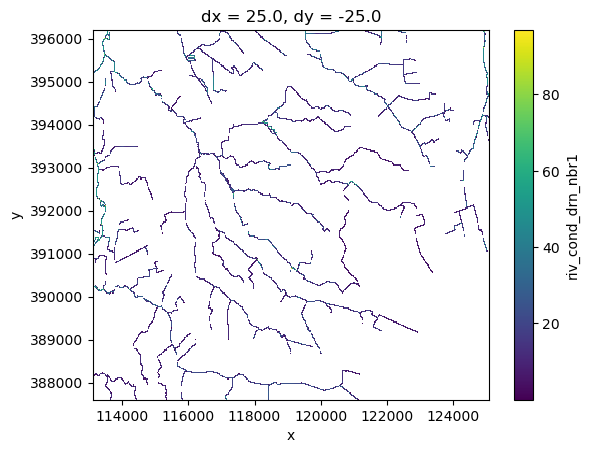

In [208]:
A_key = list(d_Pa_Cond.keys())[1]
A_whole = d_Pa_Cond[A_key]
A = A_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(A_key)
A.plot.imshow()

RIV_Cond_DETAILWATERGANGEN_NBr1.IDF


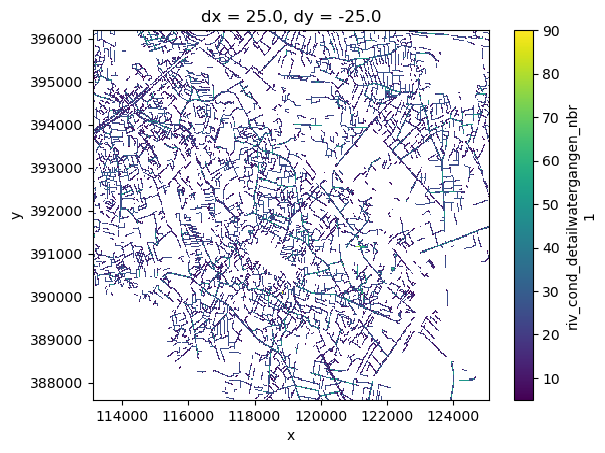

In [209]:
B_key = list(d_Pa_Cond.keys())[0]
B_whole = d_Pa_Cond[B_key]
B = B_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(B_key)
B.plot.imshow()

We've loaded the main RIV cond as A, and the detailed as B. We'll use the average for now.

Union array C: 38659 valid values, sum = 797031.0


Text(0.5, 1.0, 'Array C: Union of A and B')

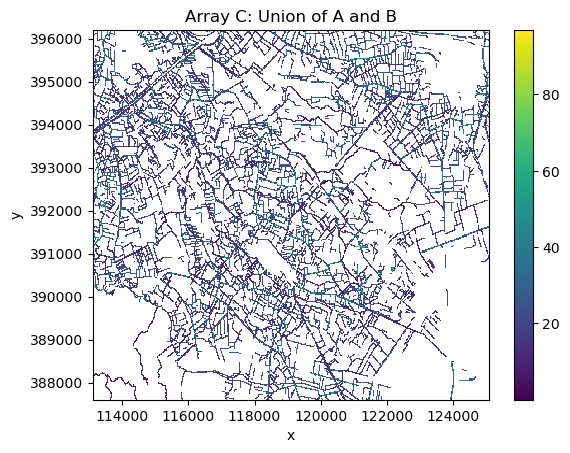

In [210]:
# Create union array C: average where both valid, single value where only one valid
C = xr.where(~np.isnan(A) & ~np.isnan(B), (A + B) / 2,  # Both valid: average
             xr.where(~np.isnan(A), A, B))                # Only one valid: use that one

print(f"Union array C: {(~np.isnan(C)).sum().values} valid values, sum = {C.sum(skipna=True).values}")
C.plot.imshow()
plt.title('Array C: Union of A and B')

In [211]:
DF_RC['RIV_Cond'] = DF_RC['Cond'].copy() # Apply conductance matching to DF_RC using array C. Start with copy of existing Cond values as fallback

C_DF_RC = C.values[DF_RC['i'].values, DF_RC['j'].values] # Get array values for all i,j coordinates at once (vectorized)

In [212]:
# Replace only where array has valid (non-NaN) values
valid_mask_RC = ~np.isnan(C_DF_RC)
DF_RC.loc[valid_mask_RC, 'RIV_Cond'] = C_DF_RC[valid_mask_RC]

In [213]:
print(f"DF_RC conductance matching results:")
print(f"Replaced {valid_mask_RC.sum()} values out of {len(DF_RC)} total rows ({valid_mask_RC.sum()/len(DF_RC)*100:.1f}%)")
print(f"Original Cond: min={DF_RC['Cond'].min():.3f}, max={DF_RC['Cond'].max():.3f}")
print(f"New RIV_Cond: min={DF_RC['RIV_Cond'].min():.3f}, max={DF_RC['RIV_Cond'].max():.3f}")

# Check how many values actually changed
changed_values_RC = (DF_RC['Cond'] != DF_RC['RIV_Cond'])
print(f"Values that changed: {changed_values_RC.sum()} out of {len(DF_RC)}")

DF_RC conductance matching results:
Replaced 21536 values out of 23901 total rows (90.1%)
Original Cond: min=6.507, max=5763.998
New RIV_Cond: min=0.036, max=3127.255
Values that changed: 21536 out of 23901


In [214]:
DF_RC['K_RIV'] = DF_RC['RIV_Cond'] * DF_RC['strthick'] / (DF_RC['width'] * DF_RC['rchlen'])

In [215]:
DF_RC['Cond_Diff'] = DF_RC['RIV_Cond'] - DF_RC['Cond']

In [216]:
DF_RC.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [217]:
DF_reach['strhc1'] = DF_RC['K_RIV'] # Set it back to DF_reach

### 3.2.5 Explore segments

In [218]:
DF_Sgm = SFR_data.segment_data.copy()

In [219]:
DF_Sgm.iloc[:].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Most columns aren't interesting. Let's plot the interesting ones.

In [220]:
DF_Sgm[["nseg", "outseg", "roughch", "elevup", "elevdn", "width1", "width2", ]]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [221]:
(DF_Sgm['width1'] == DF_Sgm['width1']).all()

np.True_

In [222]:
(DF_Sgm['elevup'] >= DF_Sgm['elevdn']).all()

np.True_

We can see:
- the roughness values are all the same (default) - **OK**
- downstream elevation is always lower than (or equal to) upstream - **OK**
- the widths seem to be the ones read from the shapefile - **OK**

### 3.2.6 Add OBS

In [223]:
help(SFR_data.add_observations)

Help on method add_observations in module sfrmaker.sfrdata:

add_observations(
    data,
    flowline_routing=None,
    obstype=None,
    sfrlines_shapefile=None,
    x_location_column=None,
    y_location_column=None,
    line_id_column=None,
    rno_column=None,
    obstype_column=None,
    obsname_column='site_no',
    gage_starting_unit_number=250
) method of sfrmaker.sfrdata.SFRData instance



In [224]:
Pa_SFR_OBS_In = PJ(d_Pa['In'], f'OBS/SFR/NBr40/NBr40_SFR_OBS_Pnt.csv') #666 Should be PJ(d_Pa['In'], f'OBS/SFR/{MdlN}/{MdlN}_SFR_OBS_Pnt.csv')
DF_SFR_OBS = pd.read_csv(Pa_SFR_OBS_In)
DF_SFR_OBS

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [225]:
for i, row in DF_SFR_OBS.iterrows(): # Have to add them one by one, otherwise it groups them by reach and only keeps the 1st one. This is an SFRmaker bug, I can fix that later and make a pull request.
    SFR_data.add_observations(
        pd.DataFrame(row).T,
        x_location_column='x',  
        y_location_column='y',
        obstype_column='obstype',
        obsname_column='site_no'
        )

In [226]:
SFR_data.observations

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 3.2.7 Run diagnostics

In [227]:
SFR_data.run_diagnostics(verbose=True)


Running Flopy v. 3.9.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or modelgrid object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-23901 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
1015 reaches encountered with strtop < strtop of downstream reach.
Elevation rises:
i j iseg ireach strtop strtopdn d_strtop reachID diff
261 268 58 4 11.347026824951172 15.830265998840332 4.48323917388916 637 -4.48323917388916
260 268 57 25 11.3853120803833 15.830265998840332 4.444953

Most checks passed, except for: #666 need to re-check
1. Checking reach_data for downstream rises in streambed elevation...<br>68 reaches encountered with strtop < strtop of downstream reach. Let's see if this causes a problem.
2. Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This can be fixed easily with one of the SFRdata options. We'll come here if it causes an error in the Sim.
3. floppy Mdl not connected to SFRdata means:<br>
    3.1 Cannot check reach proximities
    3.2 Cannot check streambed elevations against cell bottom elevations. This shouldn't be a problem as the assign_layers function uses strbedthck (to assign k).


In [228]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['B_'] < 0]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are fewer entries in the GDF_Elv where the DStr Elv > UStr Elv, but this DF contains segments, not reaches. So this is expected.

## 3.3 Write file and add to NAM

In [229]:
SFR_data.reach_data = DF_reach

In [230]:
SFR_data.write_package(d_Pa['SFR'], version='mf6')

SFRmaker v. 0.12.1

Running Flopy v. 3.9.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or modelgrid object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-23901 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
1015 reaches encountered with strtop < strtop of downstream reach.
Elevation rises:
k i j iseg ireach strtop strtopdn d_strtop reachID diff
9 261 268 58 4 11.347026824951172 15.830265998840332 4.48323917388916 637 -4.48323917388916
9 260 268 57 25 11.3853120803833 15

In [231]:
# Try to find an inteernal SFRmaker way to fix this later. This is just a temporary patch.
with open(d_Pa['SFR'], 'r+', encoding='cp1252') as f:
    content = f.read()
    content = content.replace(f"FILEIN {MdlN}.SFR6.obs", f"FILEIN imported_model/{MdlN}.SFR6.obs")
    content = content.replace('BUDGET FILEOUT', '#BUDGET FILEOUT')
    f.seek(0)
    f.truncate()
    f.write(content)

In [232]:
# os.rename('model_SFR.chk', PJ(d_Pa['MF6'], 'imported_model/model_SFR.chk'))

In [233]:
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

In [234]:
l_Lns_NAM.insert(-1, f"  sfr6 imported_model/{PBN(d_Pa['SFR'])} sfr\n")

In [235]:
with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

# 4. Connect DRN to SFR

### 4.3.1 Prepare DF

In [236]:
base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
l_DRN_Pa = [PJ(base, folder, fname)
             for folder in folders
             for fname in os.listdir(PJ(base, folder))
             if os.path.isfile(PJ(base, folder, fname))]
# l_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [237]:
def read_mf6_drn_bin(filepath: str | Path) -> pd.DataFrame:
    """Read MODFLOW 6 DRN binary input (imod format) into a DataFrame."""
    dtype = np.dtype([
        ("k",    "<i4"),   # layer
        ("i",    "<i4"),   # row
        ("j",    "<i4"),   # column
        ("elev", "<f8"),   # elevation
        ("cond", "<f8"),   # conductance
    ])
    path = Path(filepath)
    nrec = path.stat().st_size // dtype.itemsize
    arr = np.fromfile(path, dtype=dtype, count=nrec)
    return pd.DataFrame(arr)

In [238]:
d_DRN_DF = {}

for i in range(len(l_DRN_Pa)):
    DF_DRN = read_mf6_drn_bin(l_DRN_Pa[i])
    d_DRN_DF[int(re.search(r'(?i)drn[-_]?(\d+)', PDN(l_DRN_Pa[i])).group(1))] = DF_DRN.loc[ ~DF_DRN['i'].isin([1, N_R]) & ~DF_DRN['j'].isin([1, N_C]) ]

In [239]:
for k in d_DRN_DF.keys():
    # print(f"DRN-{k} DataFrame shape: {d_DRN_DF[k].shape}")
    d_DRN_DF[k] = U.Calc_DF_XY(d_DRN_DF[k], X_Ogn, Y_Ogn, cellsize)
    d_DRN_DF[k].drop(columns=['cond', 'elev'], inplace=True)
    d_DRN_DF[k]['Pkg1'] = f'drn-{k}'
    d_DRN_DF[k]['Pvd_ID'] = d_DRN_DF[k].index + 1  # 1-based index

In [240]:
DF_reach_for_DRN = U.Calc_DF_XY(DF_reach[['rno', 'i', 'j']], X_Ogn, Y_Ogn, cellsize)

In [241]:
# Combine all DRN DataFrames and match with reach points by minimum distance
from scipy.spatial.distance import cdist

# Combine all d_DRN_DF items into a single DataFrame  
DF_DRN_all = pd.concat(d_DRN_DF.values(), ignore_index=True)

# Calculate distances and find closest reach for each DRN point
drn_coords = DF_DRN_all[['X', 'Y']].values
reach_coords = DF_reach_for_DRN[['X', 'Y']].values
distances = cdist(drn_coords, reach_coords, metric='euclidean')
min_indices = np.argmin(distances, axis=1)

# Add matched reach data to DRN DataFrame
matched_reach_data = DF_reach_for_DRN.iloc[min_indices].reset_index(drop=True)
DF_DRN_all_matched = DF_DRN_all.copy()
DF_DRN_all_matched['Rcv_ID'] = matched_reach_data['rno'].values
DF_DRN_all_matched['distance_to_match'] = distances[np.arange(len(drn_coords)), min_indices]

print(f"Combined {len(DF_DRN_all):,} DRN points from {len(d_DRN_DF)} DataFrames")
print(f"Matched to {DF_DRN_all_matched['Rcv_ID'].nunique()} unique reaches")
print(f"Mean distance: {DF_DRN_all_matched['distance_to_match'].mean():.0f}m")

Combined 188,797 DRN points from 3 DataFrames
Matched to 23678 unique reaches
Mean distance: 201m


In [242]:
# # Quick summary of matching results
# print(f"Results: {len(DF_DRN_all_matched):,} DRN points matched")
# print(f"Distance stats: mean={DF_DRN_all_matched['distance_to_match'].mean():.0f}m, "
#       f"perfect_matches={(DF_DRN_all_matched['distance_to_match'] == 0).sum():,}")
# print(DF_DRN_all_matched[['k', 'i', 'j', 'X', 'Y', 'Pkg1', 'Rcv_ID', 'distance_to_match']].head())

In [243]:
DF_DRN_all_matched['Pkd2'] = 'sfr'

In [244]:
DF_DRN_write = DF_DRN_all_matched[['Pkg1', 'Pvd_ID', 'Pkd2', 'Rcv_ID']]
DF_DRN_write['MVR_TYPE'] = 'FACTOR'
DF_DRN_write['value'] = 1
DF_DRN_write

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 4.3.2 Write MVR file

In [245]:
Pa_MVR = PJ(d_Pa['Sim_In'], f'{MdlN}.MVR6')

In [246]:
with open(Pa_MVR, 'w') as f:
    f.write(f"""BEGIN OPTIONS
END OPTIONS

BEGIN DIMENSIONS
    MAXMVR {DF_DRN_write.shape[0]}
    MAXPACKAGES {len(d_DRN_DF.keys())+1}
END DIMENSIONS

BEGIN PACKAGES
    {'\n    '.join([f"drn-{k}" for  k in d_DRN_DF.keys()])}
    sfr
END PACKAGES

BEGIN PERIOD 1
""")
    f.write(U.DF_to_MF_block(DF_DRN_write))
    f.write('END PERIOD')

In [247]:
# Insert MVR line to NAM
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

l_Lns_NAM.insert(-1, f"  MVR6 imported_model/{PBN(Pa_MVR)} MVR\n")

with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

In [248]:
# Add MOVER option to SFR
with open(d_Pa['SFR'], 'r') as f1:
    l_Lns_SFR = f1.readlines()  

l_Lns_SFR.insert(3, f"  MOVER\n")

with open(d_Pa['SFR'], 'w') as f2:
    f2.writelines(l_Lns_SFR)

In [249]:
# Add MOVER option to DRN files
for i in d_DRN_DF.keys():
    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'r') as f1:
        l_Lns_DRN = f1.readlines()  

    l_Lns_DRN.insert(3, f"  MOVER\n")

    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'w') as f2:
        f2.writelines(l_Lns_DRN)

# 5. Correct mete_grip paths

In [250]:
U.mete_grid_add_missing_Cols(PJ(d_Pa['Pa_MdlN'], 'metaswap/mete_grid.inp'))